In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from dataloaders.nascar import NascarDataLoader
from dataloaders.bouncing_data import BouncingBallDataLoader
from torch.utils.data import DataLoader
from models.VRSLDS import VRSLDS

### Load NASCAR dataset

12500
torch.Size([4, 400, 10])
torch.Size([4, 400, 2])
torch.Size([4, 400])


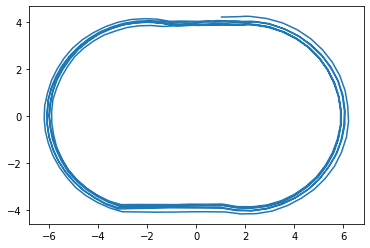

In [70]:
T=400
dl = NascarDataLoader('/data2/users/cb221/nascar_fast.npz', T)
print(len(dl))
train_loader = torch.utils.data.DataLoader(dl, batch_size=4, shuffle=True)
y, x, z = next(iter(train_loader))
print(y.size())
print(x.size())
print(z.size())
plt.plot(x[0,:,0], x[0,:,1])

### Load instead ball dataset

In [2]:
dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data_squares_4_vel/train')
train_loader = DataLoader(dl, batch_size=4, shuffle=True, num_workers=4)
obs_dim = next(iter(train_loader))[1].size(-1)
_, y = next(iter(train_loader))

In [6]:
vrslds = VRSLDS(obs_dim=10, discr_dim=4, cont_dim=2, hidden_dim=128, num_rec_layers=5, SB=True, posterior='factorised').float()
print(vrslds)
vrslds = VRSLDS(obs_dim=10, discr_dim=4, cont_dim=2, hidden_dim=128, num_rec_layers=5, SB=True, posterior='factorised').float()
checkpoint = torch.load('/data2/users/cb221/stored_models/nascar_5_lstm_factorised_seq_len_400_latest.pth.tar', map_location=torch.device('cpu'))
vrslds.load_state_dict(checkpoint['vrnn'])

VRSLDS(
  (encoder): SequentialEncoder(
    (lstm_encoder): LSTM(10, 128, num_layers=5, batch_first=True, bidirectional=True)
  )
  (out_discr): MLP(
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc_final): Linear(in_features=128, out_features=4, bias=True)
  )
  (out_cont_mean): MLP(
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc_final): Linear(in_features=128, out_features=2, bias=True)
  )
  (out_cont_log_var): MLP(
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc_final): Linear(in_features=128, out_features=2, bias=True)
  )
  (C): Linear(in_features=2, out_features=10, bias=True)
  (A): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): L

<All keys matched successfully>

In [104]:
y_pred, x_sample, z_sample, losses = vrslds(y.float()[:,:])
print(y_pred.size())
print(x_sample.size())
print(z_sample.size())
print(losses)
x_sample = x_sample.detach()
pred_states = z_sample.argmax(-1)
print(pred_states)
print(z)
print(F.mse_loss(y_pred,y[:,:]))

torch.Size([4, 400, 10])
torch.Size([4, 400, 2])
torch.Size([4, 400, 4])
{'kld': tensor(287410.7500, grad_fn=<AddBackward0>), 'elbo': tensor(444187.6250, grad_fn=<AddBackward0>), 'loss': tensor(444187.6250, grad_fn=<AddBackward0>)}
tensor([[0, 0, 0,  ..., 3, 3, 0],
        [3, 3, 3,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 1],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[2, 2, 2,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 3, 3, 3],
        [0, 0, 0,  ..., 2, 2, 0],
        [0, 0, 0,  ..., 2, 2, 2]], dtype=torch.int32)
tensor(0.0078, dtype=torch.float64, grad_fn=<MseLossBackward>)


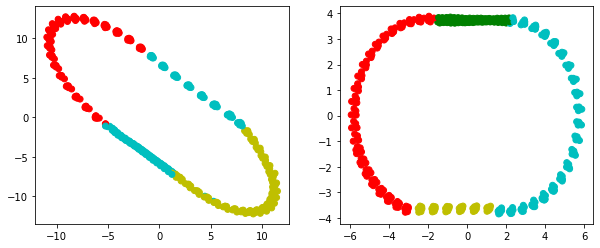

In [44]:
b=1
colors = np.array(['c', 'r', 'g', 'y'])
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(x_sample[b,:,0], x_sample[b,:,1], color=colors[pred_states[b]])
plt.subplot(122)
plt.scatter(x[b,:,0], x[b,:,1], color=colors[z[b]])
plt.show()

In [143]:
pred_states[1]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [146]:
T=60
z_pred_seq_g = torch.zeros(x_sample.size(0), T, vrslds.discr_dim).to(x_sample.device)
x_pred_seq_g = torch.zeros(x_sample.size(0), T, vrslds.cont_dim).to(x_sample.device)
z_samp_i = z_sample[:,53,:]
x_samp_i = x_sample[:,53,:]
z_pred_seq_g[:,0,:] = z_samp_i
x_pred_seq_g[:,0,:] = x_samp_i
for t in range(T-1):
        # z_t+1 | x_t, z_t
        z_next = vrslds._decode_latent_z(z_samp_i, x_samp_i)
        z_next = torch.zeros_like(z_next)
        z_next[:,0] = 1
        # x_t+1 | x_t, z_t+1
        x_next = vrslds._decode_latent_x(z_next, x_samp_i)

        z_samp_i = z_next
        x_samp_i = x_next
        z_pred_seq_g[:,t+1,:] = z_samp_i
        x_pred_seq_g[:,t+1,:] = x_samp_i
x_pred_seq_g = x_pred_seq_g.detach()
pred_states_seq_g = z_pred_seq_g.argmax(-1).detach().numpy()

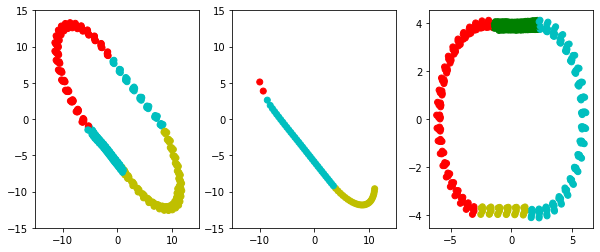

In [145]:
b=1
colors = np.array(['c', 'r', 'g', 'y'])
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.scatter(x_sample[b,:,0], x_sample[b,:,1], color=colors[pred_states[b]])
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.subplot(132)
plt.scatter(x_pred_seq_g[b,:,0], x_pred_seq_g[b,:,1], color=colors[pred_states_seq_g[b]])
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.subplot(133)
plt.scatter(x[b,:,0], x[b,:,1], color=colors[z[b]])

plt.show()

(-15.0, 15.0)

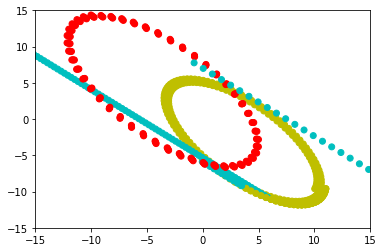

In [148]:
colors = np.array(['c', 'r', 'g', 'y'])
plt.scatter(x_pred_seq_r[b,:,0], x_pred_seq_r[b,:,1], color=colors[pred_states_seq_r[b]])
plt.scatter(x_pred_seq_c[b,:,0], x_pred_seq_c[b,:,1], color=colors[pred_states_seq_c[b]])
plt.scatter(x_pred_seq_a[b,:,0], x_pred_seq_a[b,:,1], color=colors[pred_states_seq_a[b]])
plt.scatter(x_pred_seq_g[b,:,0], x_pred_seq_g[b,:,1], color=colors[pred_states_seq_g[b]])
plt.xlim(-15,15)
plt.ylim(-15,15)

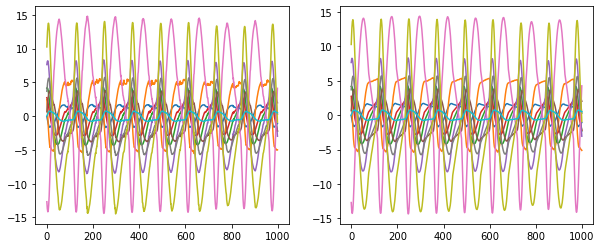

In [89]:
plt.figure(figsize=(10,4))
plt.subplot(121)
for i in range(10):
    plt.plot(y_pred[b,:,i].detach())
plt.subplot(122)
for i in range(10):
    plt.plot(y[b,:,i].detach())
plt.show() 

In [53]:
T=300
z_pred_seq1 = torch.zeros(x_sample.size(0), T, vrslds.discr_dim).to(x_sample.device)
x_pred_seq1 = torch.zeros(x_sample.size(0), T, vrslds.cont_dim).to(x_sample.device)
z_samp_i = z_sample[:,-1,:]
x_samp_i = x_sample[:,-1,:]
for t in range(T):
        # z_t+1 | x_t, z_t
        z_next = vrslds._decode_latent_z(z_samp_i, x_samp_i)
        z_next = torch.zeros_like(z_next)
        z_next[:,2] = 1
        # x_t+1 | x_t, z_t+1
        x_next = vrslds._decode_latent_x(z_next, x_samp_i)

        z_samp_i = z_next
        x_samp_i = x_next
        z_pred_seq1[:,t,:] = z_samp_i
        x_pred_seq1[:,t,:] = x_samp_i
y_pred_seq = vrslds._decode_y(x_pred_seq1)
x_pred_seq1 = x_pred_seq1.detach()
pred_seq_states1 = z_pred_seq1.argmax(-1).detach().numpy()

(-5.0, 5.0)

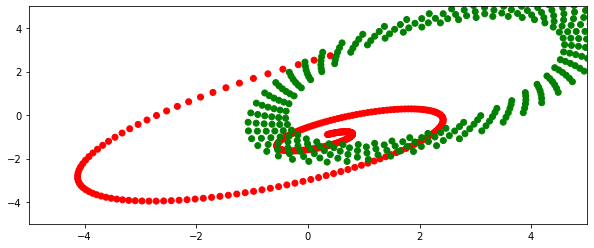

In [54]:
b=1
colors = np.array(['c', 'r', 'g', 'y'])
plt.figure(figsize=(10,4))
plt.scatter(x_pred_seq[b,20:,0], x_pred_seq[b,20:,1], color=colors[pred_seq_states[b,20:]])
plt.scatter(x_pred_seq1[b,20:,0], x_pred_seq1[b,20:,1], color=colors[pred_seq_states1[b,20:]])
plt.xlim(-5,5)
plt.ylim(-5,5)

#### Bouncing ball data viz

In [4]:
y_pred, x_sample, z_sample, losses = vrslds(y.float()[:,:50])
print(y_pred.size())
print(x_sample.size())
print(z_sample.size())
print(losses)
x_sample = x_sample.detach()
pred_states = z_sample.argmax(-1)
print(pred_states)
print(F.mse_loss(y_pred,y[:,:50]))

torch.Size([4, 50, 2])
torch.Size([4, 50, 2])
torch.Size([4, 50, 4])
{'kld': tensor(208.4986, grad_fn=<AddBackward0>), 'elbo': tensor(256.9891, grad_fn=<AddBackward0>), 'loss': tensor(256.9891, grad_fn=<AddBackward0>)}
tensor([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3]])
tensor(9.6981e-05, dtype=torch.float64, grad_fn=<MseLossBackward>)


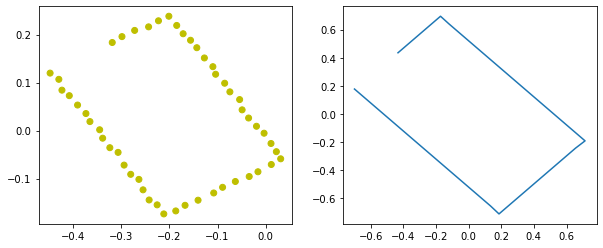

In [5]:
b=1
colors = np.array(['c', 'r', 'g', 'y'])
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(x_sample[b,:,0], x_sample[b,:,1], color=colors[pred_states[b]])
plt.subplot(122)
plt.plot(y[b,:,0], y[b,:,1])
plt.show()

In [11]:
z_pred_seq = torch.zeros(x_sample.size(0), 50, vrslds.discr_dim).to(x_sample.device)
x_pred_seq = torch.zeros(x_sample.size(0), 50, vrslds.cont_dim).to(x_sample.device)
z_samp_i = z_sample[:,0,:]
x_samp_i = x_sample[:,0,:]
z_pred_seq[:,0,:] = z_samp_i
x_pred_seq[:,0,:] = x_samp_i
for t in range(49):
        # z_t+1 | x_t, z_t
        z_next = vrslds._decode_latent_z(z_samp_i, x_samp_i)
        # x_t+1 | x_t, z_t+1
        x_next = vrslds._decode_latent_x(z_next, x_samp_i)

        z_samp_i = z_next
        x_samp_i = x_next
        z_pred_seq[:,t+1,:] = z_samp_i
        x_pred_seq[:,t+1,:] = x_samp_i
x_pred_seq = x_pred_seq.detach()
pred_states_seq = z_pred_seq.argmax(-1).detach().numpy()

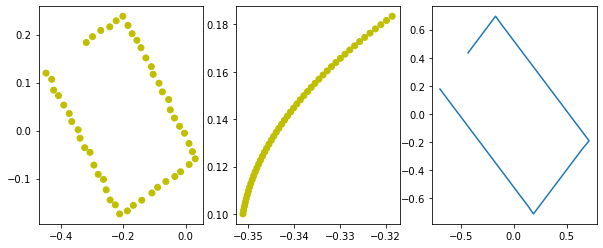

In [14]:
b=1
colors = np.array(['c', 'r', 'g', 'y'])
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.scatter(x_sample[b,:,0], x_sample[b,:,1], color=colors[pred_states[b]])
plt.subplot(132)
plt.scatter(x_pred_seq[b,:,0], x_pred_seq[b,:,1], color=colors[pred_states_seq[b]])
plt.subplot(133)
plt.plot(y[b,:,0], y[b,:,1])
plt.show()